In [ ]:
from __future__ import print_function
import torch
from utils import Plotting,accuracy_plotting
from model1 import model_1,model_2,model_3,model_4,model_summary
#from model import model_1,model_summary
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.2, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #rightness=0.10, contrast=0.1,transforms.ColorJitter(b saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


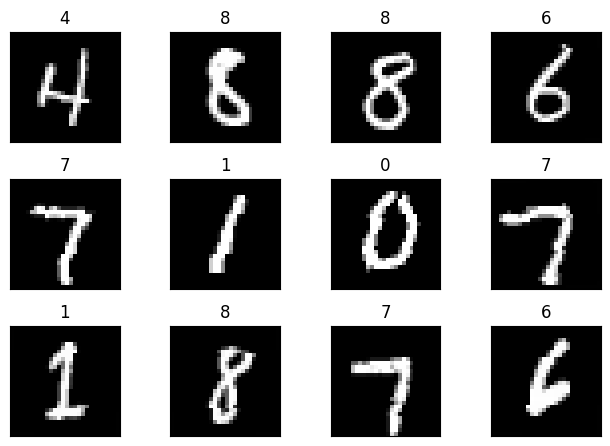

In [ ]:
Plotting(train_loader)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = model_2().to(device)
model_summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             584
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7            [-1, 8, 28, 28]             584
              ReLU-8            [-1, 8, 28, 28]               0
       BatchNorm2d-9            [-1, 8, 28, 28]              16
        MaxPool2d-10            [-1, 8, 14, 14]               0
          Dropout-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 14, 14]             876
             ReLU-13           [-1, 12, 14, 14]               0
      BatchNorm2d-14           [-1, 12,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09188266843557358 Batch_id=468 Accuracy=93.27: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s]



Test set: Average loss: 0.0717, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.06436298042535782 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:41<00:00, 11.44it/s]



Test set: Average loss: 0.0483, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.052949707955121994 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]



Test set: Average loss: 0.0515, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.029580170288681984 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:41<00:00, 11.29it/s]



Test set: Average loss: 0.0357, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.08752471953630447 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:41<00:00, 11.28it/s]



Test set: Average loss: 0.0307, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.047248467803001404 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s]



Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.020663343369960785 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:42<00:00, 10.94it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.05878886207938194 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]



Test set: Average loss: 0.0287, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.016869818791747093 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:41<00:00, 11.20it/s]



Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.029949532821774483 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:41<00:00, 11.40it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.008267507888376713 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.0596843846142292 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]



Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.01581927202641964 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]



Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.12309321016073227 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:39<00:00, 11.77it/s]



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.014191485941410065 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s]



Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)



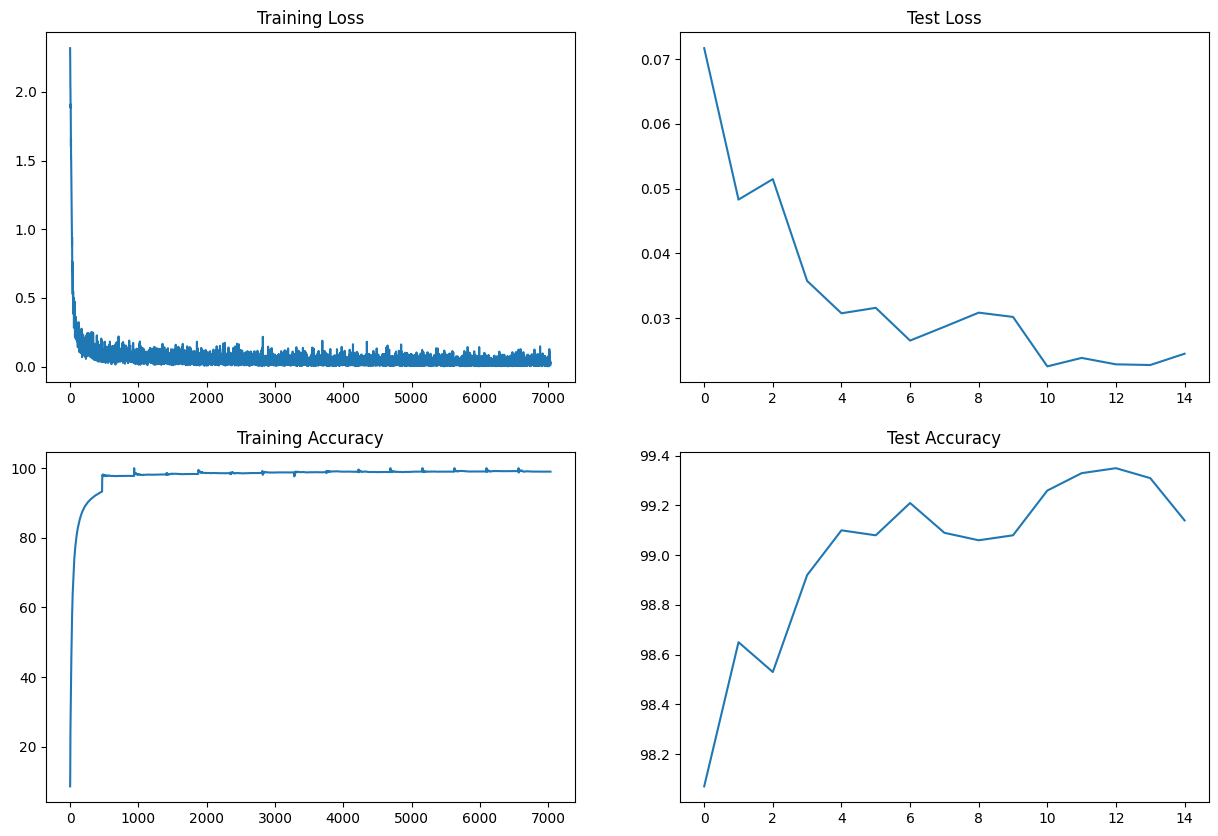

In [ ]:
accuracy_plotting(train_losses,train_acc,test_losses,test_acc)